# <font color='White'>Table of contents<font><a class='anchor' id='top'></a>
- [Prompt](#0)
- [Understanding the Business Goals](#1)
    - [Clarifying The Main Goal](#1-1)
    - [Key Assumptions](#1-2)
    - [Constraints](#1-3)
    - [Key Performance Indicators](#1-4)
    - [Understanding The Data](#1-5)

- [Question 1: Generating Synthetic Data](#2)
- [Optimization Algorithm](#3)
- [Question 2: Maxmize Sales](#4)
- [Question 3: Maxmize Margin](#5)
- [Question 4: Sales Target While Maximizing Margins](#6)
- [Question 5: Margin Target While Maximizing Sales](#7)
- [Question 6: 5 year fore casting using Monte Carlo Simulations](#8)
- [Thoughts & Reflections](#9)


## Prompt <a class='anchor' id='0'></a>


### Directions

In [1]:
%%html
from IPython.display import IFrame, display
display(IFrame("Case_Study.pdf", width=800, height=600))

### Organization Chart

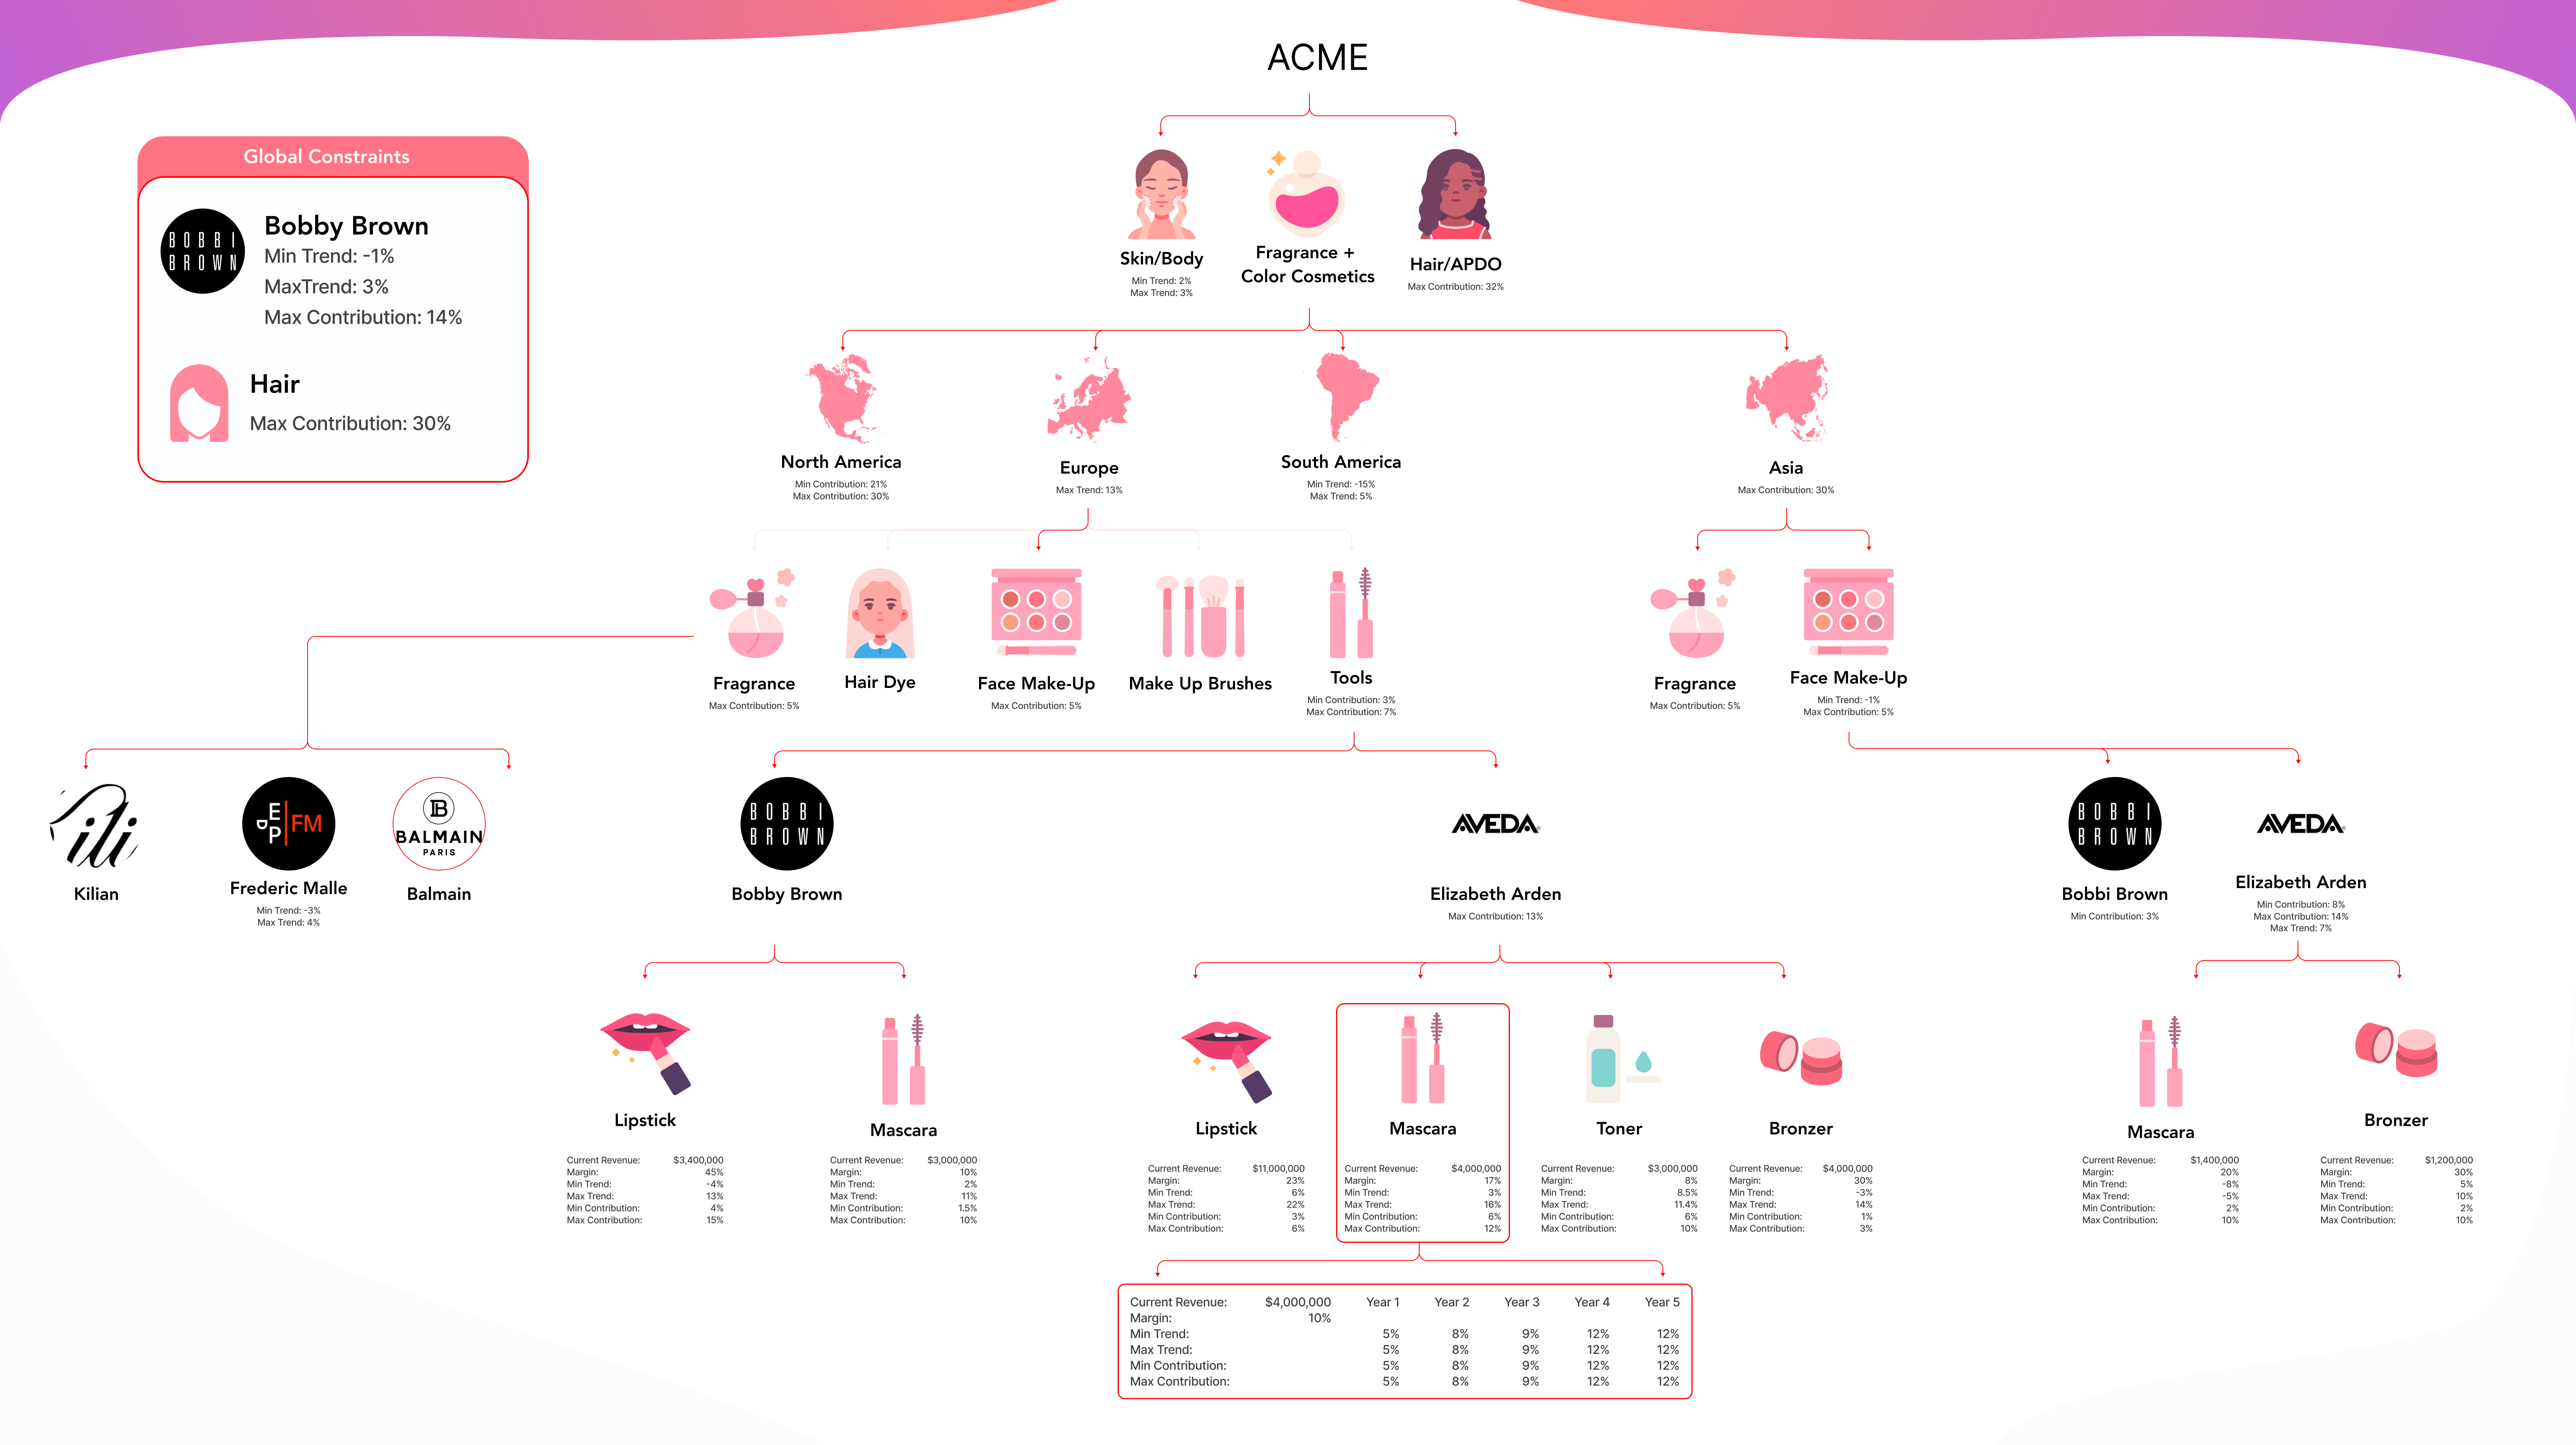

In [2]:
from IPython.display import Image
img = Image("Acme_Org_Chart.png", width=1200, height=600)
img

## Understanding The Business Goals <a class='anchor' id='1'></a>




### What is the Main Goal? <a class='anchor' id='1-1'></a>

This problem is very similar to managing a portfolio of stocks, In that the main goal is to determine the optimal portfolio blend for each sub-company within Acme algorithmically by:

- Optimizing Key Performance Indicators (KPIs)
    - Balancing metrics like total sales, profit margins, and growth trends to maximize overall performance.
- Accounting for Trends and Constraints:
    - Factoring in predicted market trends and operational constraints (like contribution ratios that must sum to 100% at the segment level) to simulate realistic scenarios and outcomes.
- Scenario-Based Decision Making:
    - Creating multiple forecasting scenarios that can help assess different strategies and risks, ultimately guiding the optimal portfolio mix for different macroeconomic enviroments.




### Key Assumptions <a class='anchor' id='1-2'></a>


Given the limited details of the organization chart we are going to have to make some important assumptions that will dictate how this problem is approached.

- Minimum and Maximum trend constraints are fixed within the 5 year time frame and are not fluctuating due to outside Macroeconomic factors
- Trends are normally distributed with a mean in the average of the minum and maximum trend and therefore can be modeled using a monte carlo simulation. 
- There is no cost to changing the contribution amount for each segment 
- Each segment is independent and the trends of similar categories do not correlate
- The sum of every max contribution % is less than 100 therefore I am scaling the data to correct this 
    - Addressing Global constraints before normalization
- Trends propagate down the org chart, (i.e. if europe as a whole is trending then the products within europe will also account for this)
    - This also means that the revenue is propagated upward to represent totals
- Removing Units that do not have enough data to influence any decision makeing, such as the fragrance category in Europe which provides no information that is helpful when optimizing the porfolio

### Constraints <a class='anchor' id='1-3'></a>

What are the main limitations?

- Companies have minimum and maximum contribution amounts 
- hierarchal structure, The constraints of entities higher in the chart affect the descendents

### Key Performance Indicators <a class='anchor' id='1-4'></a>

What metrics are important and why? 

- Margin
    - Measures the difference between revenue and expenses 
    - "How efficient are we?"

- Sales
    - Measures the total amount of sales
    - "How effective are we?"

- Risk 
    - How much variability is there in the trend

### Understanding The Data<a class='anchor' id='1.5'></a>

| **Term**                     | **Definition**                                                                                                                                                         |
|------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Sales**                    | Total sales for that particular unit (provided as an initial input).                                                                                                   |
| **Margin**                   | Profit for the unit (provided as an initial input) and typically remains constant year-to-year.                                                                        |
| **Trend**                    | The predicted growth Acme expects for the unit, reflecting market trends (can also be negative).                                                                        |
| **Contribution**             | The percentage of the overall portfolio that the unit comprises. At the segment level, all segments within a brand must sum to 1 (100%).                                |
| **New Sales for each Segment** | The output representing new sales generated for each segment after the algorithm is executed.                                                                           |
| **New Contribution**         | The new contribution percentage calculated for a segment, brand, category, etc., as a result of the algorithm's execution.                                               |


### How do we do accomplish our goals?  <a class='anchor' id='1.6'></a>

1. Generate synthetic data for each company that align with the general constraints.
    - Accounting for the hierarchal dynamic 
2. Bottom-Up optimization
    - optimize the blend of contributions of segments for each layer.
3. Monte Carlo Simulation for time
    - Run simulations for different startegies seeing the results over time 


In [3]:
from figure_settings.fig_settings import *
from helpers import * 
from optimizer import *
from monte_carlo import *
import pandas as pd 
import numpy as np
import copy

## Question 1. Generating Synthetic Data<a class='anchor' id='2'></a>

Since the companies have the saem attributes using a class keeps these values contained

In [4]:
import copy

class Unit:
    def __init__(self, Name=None, Revenue=0, Margin=0, Min_Trend=0, Max_Trend=0, Min_Contribution=0, Max_Contribution=1):
        self.Name = Name
        
        self.Max_Contribution = Max_Contribution
        self.Min_Contribution = Min_Contribution
        self.Contribution = (self.Max_Contribution + self.Min_Contribution) / 2  # Intitialize in the middle
        
        self.Revenue = float(Revenue)  * self.Contribution
        self.Margin = float(Margin)  
        self.Weighted_Margin = self.Margin * self.Revenue  * self.Contribution 

        self.Min_Trend = Min_Trend
        self.Max_Trend = Max_Trend
        self.Volatility = self.Max_Trend - self.Min_Trend
    

        self.sub_units = []

    def add_unit(self, sub_unit):
        self.sub_units.append(sub_unit)

    def clear_units(self):
        self.sub_units = []

    def copy(self):
        """Creates a deep copy of the tree structure, including sub-units."""
        new_unit = Unit(
            Name=self.Name,
            Revenue=self.Revenue,
            Margin=self.Margin,
            Min_Trend=self.Min_Trend,
            Max_Trend=self.Max_Trend,
            Min_Contribution=self.Min_Contribution,
            Max_Contribution=self.Max_Contribution
        )
        # Recursively copy all child units
        new_unit.sub_units = [child.copy() for child in self.sub_units]
        return new_unit




Due to the hierarchal structure of the data it makes sense to model the organization as a tree 

In [5]:

Acme = {
        'Unit': Unit(Name='Total', Min_Contribution=1),
        'Children': [
                {
                'Unit': Unit(Name = 'Skin/Body', Min_Trend=.02, Max_Trend=.03),
                'Children': []
                },
                {
                'Unit':Unit(Name = 'Fragrances'),
                'Children': [
                        {
                        'Unit': Unit(Name = 'NA', Min_Contribution=.21, Max_Contribution=.30),
                        'Children': []
                        },
                        {
                        'Unit': Unit(Name = 'EU', Max_Trend=.12),
                        'Children': [
                                {
                                'Unit': Unit(Name = 'Tools', Min_Contribution=.03, Max_Contribution=.07),
                                'Children': [
                                    
                                        {
                                        'Unit': Unit(Name = 'Elizabeth_Arden', Max_Contribution=.13),
                                        'Children': [
                                                {
                                                'Unit': Unit(Name = 'Lipstick', Revenue=11, Margin=.23, Min_Trend=.06, Max_Trend=.22, Min_Contribution=.03, Max_Contribution=.06),
                                                'Children': []
                                                },
                                                {
                                                'Unit': Unit(Name = 'Mascara', Revenue=4, Margin=.17, Min_Trend=.03, Max_Trend=.16, Min_Contribution=.06, Max_Contribution=.12),
                                                'Children': []
                                                },
                                                {
                                                'Unit': Unit(Name = 'Toner', Revenue=3, Margin=.08, Min_Trend=.085, Max_Trend=.114, Min_Contribution=.06, Max_Contribution=.1),
                                                'Children': []
                                                },
                                                {
                                                'Unit': Unit(Name = 'Bronzer', Revenue=4, Margin=.3, Min_Trend=-.03, Max_Trend=.14, Min_Contribution=.01, Max_Contribution=.03),
                                                'Children': []
                                                },
                                                ]
                                        },
                                        {
                                        'Unit': Unit(Name = 'Billy Brown', Max_Contribution=.09),
                                        'Children': [
                                                {
                                                'Unit': Unit(Name = 'Lipstick', Revenue=3.4, Margin=.45, Min_Trend=-.04, Max_Trend=.13, Min_Contribution=.04, Max_Contribution=.15),
                                                'Children': []
                                                },
                                                {
                                                'Unit': Unit(Name = 'Mascara', Revenue=3, Margin=.10, Min_Trend=.02, Max_Trend=.11, Min_Contribution=.015, Max_Contribution=.1),
                                                'Children': []
                                                },
                                                ]
                                        },
                                ]
                                },



                        ]
                        },
                        {
                        'Unit': Unit(Name = 'South_Africa', Min_Trend=-.15, Max_Trend=.05),
                        'Children': []
                        },
                        {
                        'Unit': Unit(Name = 'Asia', Max_Contribution=.30),
                        'Children': [
                                 {
                                'Unit': Unit(Name = 'Face_Make_Up', Min_Trend=-.01, Max_Contribution=.05),
                                'Children': [
                                        {
                                        'Unit': Unit(Name = 'Elizabeth_Arden',Min_Contribution=.08,  Max_Contribution=.14, Max_Trend = .07),
                                        'Children': [
                                                {
                                                'Unit': Unit(Name = 'Mascara', Revenue=1.4, Margin=.2, Min_Trend=-.08, Max_Trend=-.05, Min_Contribution=.02, Max_Contribution=.1),
                                                'Children': []
                                                },
                                                {
                                                'Unit': Unit(Name = 'Bronzer', Revenue=4, Margin=.3, Min_Trend=.05, Max_Trend=.1, Min_Contribution=.02, Max_Contribution=.1),
                                                'Children': []
                                                },
                                                ]
                                        },
                                        {
                                        'Unit': Unit(Name = 'Billy Brown', Min_Contribution=.03),
                                        'Children': []
                                        }
                                        ]
                                },
                        ]
                        },
                ]
                },
                {
                'Unit': Unit(Name = 'Hair/ADPO', Max_Contribution=.30),
                'Children': []
                }
        ]

        }


Breadth First search traversal of hierarchy with information on each sub company

In [6]:
root = build_tree(Acme)
print_tree(root)
eval_optimizer(root)

 Level            Name  Revenue  Weighted_Revenue  Margin  Weighted_Margin  Contribution  Min_Contribution  Max_Contribution  Min_Trend  Max_Trend  Volatility
     0           Total 0.000088                 0    0.00         0.000000        1.0000          1.000000          1.000000     0.0000    0.00000         NaN
     1       Skin/Body 0.000000                 0    0.00         0.000000        0.5000          0.000000          1.000000     0.0200    0.03000     0.01000
     1      Fragrances 0.000176                 0    0.00         0.000000        0.5000          0.000000          1.000000     0.0000    0.00000         NaN
     1       Hair/ADPO 0.000000                 0    0.00         0.000000        0.1500          0.000000          0.300000     0.0000    0.00000         NaN
     2              EU 0.000337                 0    0.00         0.000000        0.5000          0.000000          1.000000     0.0000    0.12000         NaN
     2    South_Africa 0.000000               

{'Revenue': 8.817254687500002e-05,
 'Volatility': np.float64(0.010834332382812503),
 'Weighted_Margin': 0.0}

## Optimization Algorithm <a class='anchor' id='3'></a>


The basic Idea is to optimize the portoflio percentages at each level before moving up using linear programming. This means that the final results will be propagated up the tree towards the node taking a weighted average of each sub level. This could be considered a greedy approach as we expect that optimizing the contributions at the lowest level well indicate am optimal total solution


Important Definitions 

    Weighted Margin: Total amount of dollars in margin 
    Volatility: the avg volatility of companies that have an upper and lower bound for trend

## Question 2: Maximize Sales <a class='anchor' id='4'></a>

In [7]:
strat1 = bottom_up_optimizer(
    root.copy(),
    target_func=lambda x: x.Revenue
)

results = eval_optimizer(strat1)

---------------- Contributions by each sub company ----------------
 Level            Name  Revenue  Weighted_Revenue  Margin  Weighted_Margin  Contribution  Min_Contribution  Max_Contribution  Min_Trend  Max_Trend  Volatility
     0           Total 0.124642                 0    0.00         0.000000      1.000000          1.000000          1.000000     0.0000    0.00000         NaN
     1       Skin/Body 0.000000                 0    0.00         0.000000      0.000000          0.000000          1.000000     0.0200    0.03000     0.01000
     1      Fragrances 0.124642                 0    0.00         0.000000      1.000000          0.000000          1.000000     0.0000    0.00000         NaN
     1       Hair/ADPO 0.000000                 0    0.00         0.000000      0.000000          0.000000          0.300000     0.0000    0.00000         NaN
     2              EU 0.157775                 0    0.00         0.000000      0.790000          0.000000          1.000000     0.0000  

In [8]:
for k, v in results.items():
    print(f"{k}: {round(v, 3)}")

Revenue: 0.125
Volatility: 0.008
Weighted_Margin: 0.0


## Question 3: Maximize Margin <a class='anchor' id='5'></a>

In [9]:
strat2 = bottom_up_optimizer(
    root.copy(),
    target_func=lambda x: x.Weighted_Margin
)

results = eval_optimizer(strat2)

---------------- Contributions by each sub company ----------------
 Level            Name  Revenue  Weighted_Revenue  Margin  Weighted_Margin  Contribution  Min_Contribution  Max_Contribution  Min_Trend  Max_Trend  Volatility
     0           Total 0.000000                 0    0.00         0.000000      1.000000          1.000000          1.000000     0.0000    0.00000         NaN
     1       Skin/Body 0.000000                 0    0.00         0.000000      1.000000          0.000000          1.000000     0.0200    0.03000     0.01000
     1      Fragrances 0.124642                 0    0.00         0.000000      0.000000          0.000000          1.000000     0.0000    0.00000         NaN
     1       Hair/ADPO 0.000000                 0    0.00         0.000000      0.000000          0.000000          0.300000     0.0000    0.00000         NaN
     2              EU 0.157775                 0    0.00         0.000000      0.790000          0.000000          1.000000     0.0000  

In [10]:
for k, v in results.items():
    print(f"{k}: {round(v, 3)}")

Revenue: 0.0
Volatility: 0.005
Weighted_Margin: 0.0


## Question 4: Sales Target While Maximizing Margin <a class='anchor' id='6'></a>

In [11]:
strat_3 = bottom_up_optimizer(
    root.copy(),
    target_func=lambda x: x.Weighted_Margin,  
    constraint_func=lambda x: x.Revenue ,  
    constraint_value= .6
)
results = eval_optimizer(strat_3)

ValueError: Linear optimization failed!

In [ ]:
for k, v in results.items():
    print(f"{k}: {round(v, 3)}")

## Question 5: Margin Target While Maximizing Sales <a class='anchor' id='7'></a>

In [ ]:
stat_4 = bottom_up_optimizer(
    root.copy(),
    target_func=lambda x: x.Weighted_Revenue,   # Optimize for revenue
    constraint_func=lambda x: x.Weighted_Margin,  
    constraint_value= .05 * 1.450
)

ValueError: Linear optimization failed!

In [ ]:
for k, v in results.items():
    print(f"{k}: {round(v, 3)}")

Revenue: 0.0
Volatility: 0.005
Weighted_Margin: 0.0


## Question 6: 5 year projections with  Monte Carlo Simulation <a class='anchor' id='8'></a>

### Time Series provided for Europe -> Face Make-Up -> Elizabeth Arden -> Mascara

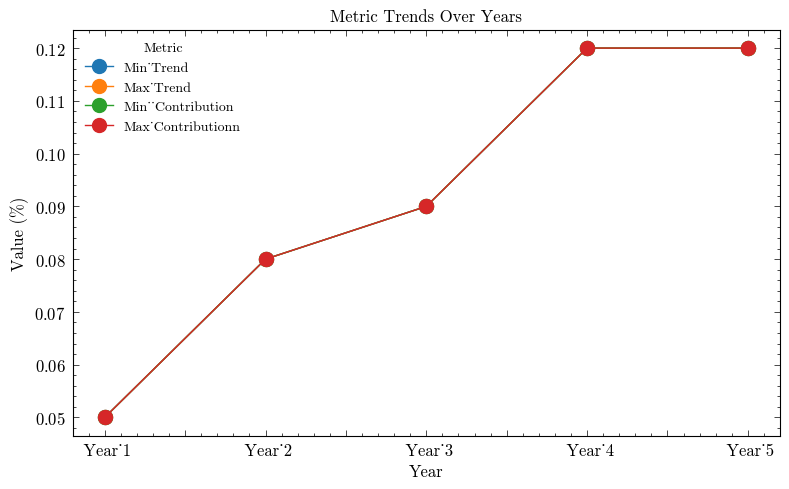

In [ ]:
df = pd.read_csv('data/sample_time_series.csv')
df.set_index("Metric", inplace=True)
df_transposed = df.transpose()
df_transposed.plot(kind="line", marker="o", figsize=(8, 5))

plt.xlabel("Year")
plt.ylabel("Value (%)")
plt.title("Metric Trends Over Years")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

To simulate stochastic process we replicate a monte carlo simulation for each strategy to model the expected behavior over time

In [15]:
strategies = [('Strategy 1-Revenue Optimized', strat1), ('Strategy 2 - Adjusted Margin Optimized', strat2)]
years = 5 

results = run_all_strategies(strategies, years )
print(results)



[{'Name': 'Strategy 1-Revenue Optimized', 'revenue': [[np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293)], [np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485279293), np.float64(0.008094059485

In [16]:

def plot_revenue(results):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate through each strategy's results and plot as a line with error bars
    for strategy in results:
        years = np.arange(1, len(strategy['revenue']) + 1)

        avg = np.array([np.mean(x) for x in strategy['revenue']])
        errors = np.array([np.std(x) for x in strategy['revenue']])  

        ax.errorbar(years, avg, yerr=errors, label=strategy['Name'], capsize=5, marker='o', linestyle='-')

    # Labels and Titles
    ax.set_title('Forecasting Strategies')
    ax.set_xlabel('Years')
    ax.set_ylabel('Total Revenue')
    
    ax.legend()
    plt.show()

def plot_margin(results):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate through each strategy's results and plot as a line with error bars
    for strategy in results:
        years = np.arange(1, len(strategy['margin']) + 1)

        avg = np.array([np.mean(x) for x in strategy['margin']])
        errors = np.array([np.std(x) for x in strategy['margin']])  

        ax.errorbar(years, avg, yerr=errors, label=strategy['Name'], capsize=5, marker='o', linestyle='-')

    # Labels and Titles
    ax.set_title('Forecasting Strategies')
    ax.set_xlabel('Years')
    ax.set_ylabel('Total Margin Adjusted by Revenue')

    ax.legend()
    plt.show()

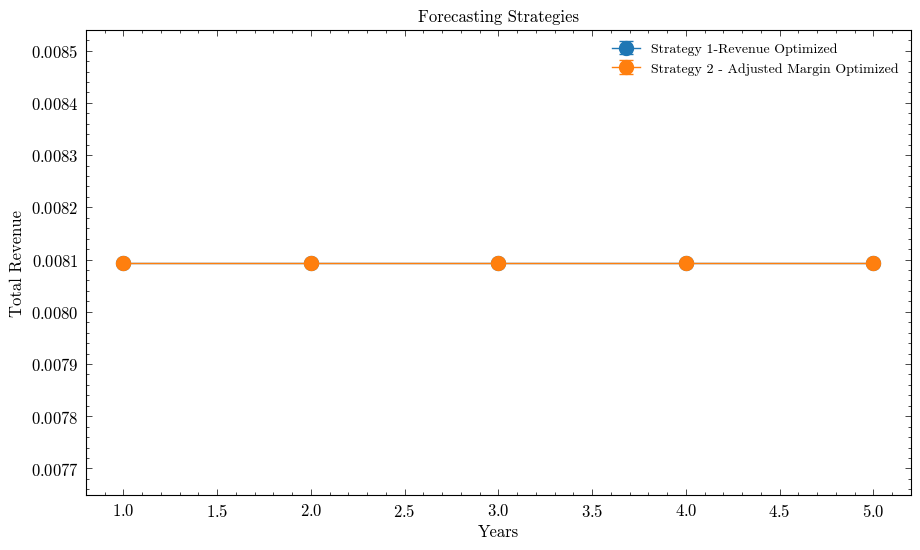

In [17]:
plot_revenue(results)

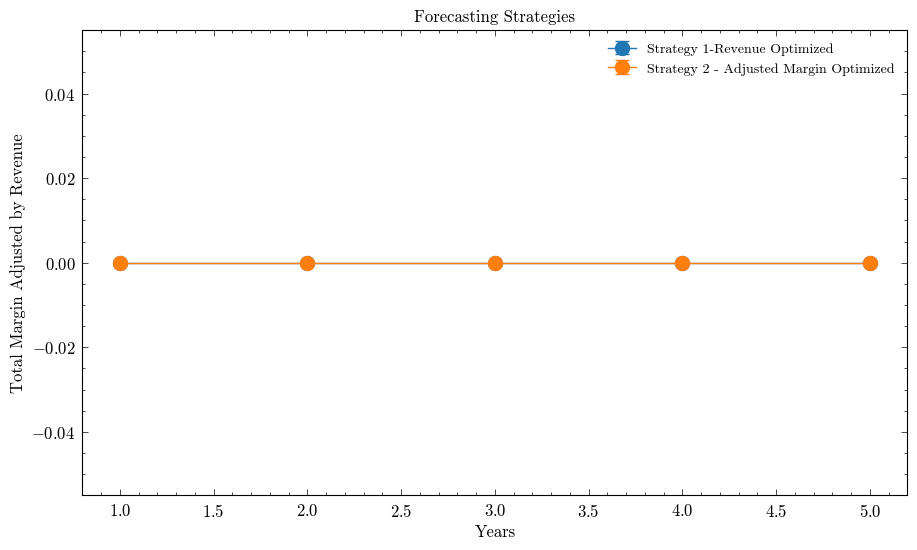

In [18]:
plot_margin(results)

## Thoughts and Reflection <a class='anchor' id='9'></a>


Unfortunately, due to time constraints, I was unable to complete the optimization algorithm. However, the framework is in place. Although the approach is complex, using a tree-based representation allows for efficient trend simulation in specific areas while maintaining hierarchical dependencies.

This structure provides flexibility in modeling different scenarios and aggregating data across multiple levels. Given more time, I would refine the optimization process to ensure that the linear optimization worked correctly. Despite the limitations, this project has provided valuable insights into the difficulties in modeling complex real world data aswell as giving me practice in how to break down a vague question into a working model.